In [3]:
import pandas as pd
import numpy as np
# 시각화 관련
import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import seaborn as sns
# score 관련
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
# 모델링 관련
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb   
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor       
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization 

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11689 sha256=c1035d78560ed050ce4c73cdfcc2ad2419f355b3d29354d80aea144a350a6e77
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\37\fa\19\f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


#raw 데이터

In [4]:
movie_raw_data=pd.read_csv("movie_data/analysis_movie_data.csv", encoding='CP949')
movie_raw_data

,순번,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,서울매출액,서울관객수,장르,등급,영화구분
0,1,명량,김한민,(주)빅스톤픽쳐스,NaN,씨제이이앤엠(주),2014-07-30,개봉영화,장편,한국,"1,587","135,748,398,910","17,613,682","33,121,225,810","4,163,666",사극,15세이상관람가,일반영화
1,2,극한직업,이병헌,"(주)어바웃필름,영화사 해그림 주식회사,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2019-01-23,개봉영화,장편,한국,"1,978","139,647,979,516","16,264,944","31,858,660,536","3,638,287",코미디,15세이상관람가,일반영화
2,3,신과함께-죄와 벌,김용화,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",NaN,롯데쇼핑㈜롯데엔터테인먼트,2017-12-20,개봉영화,장편,한국,"1,912","115,698,654,137","14,410,754","27,530,825,087","3,346,172",판타지,12세이상관람가,일반영화
3,4,국제시장,윤제균,"(주)제이케이필름,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2014-12-17,개봉영화,장편,한국,966,"110,828,014,630","14,245,998","25,842,519,330","3,233,946",드라마,12세이상관람가,일반영화
4,5,어벤져스: 엔드게임,"안소니 루소,조 루소",NaN,월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,2019-04-24,개봉영화,장편,미국,"2,835","122,182,694,160","13,934,592","33,577,136,860","3,597,963",액션,12세이상관람가,일반영화
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,S걸의 덫,그레고리 하타나카,NaN,(주)케이알씨지,(주)케이알씨지,2018-04-10,개봉영화,장편,브라질,1,"1,000",1,0,0,멜로/로맨스,청소년관람불가,일반영화
7039,7040,VIP전용 여자,카네다 사토시,NaN,(주)도키엔터테인먼트,(주)도키엔터테인먼트,2016-12-01,개봉영화,장편,일본,1,"8,000",1,0,0,성인물(에로),청소년관람불가,일반영화
7040,7041,VJ의 은밀한 사생활,오카다 히로,NaN,(주)영진크리에이티브,(주)영진크리에이티브,2017-12-25,개봉영화,장편,일본,1,"6,000",1,0,0,멜로/로맨스,청소년관람불가,일반영화
7041,7042,av감독의 아내,쿠도 마사노리,NaN,(주)도키엔터테인먼트,(주)도키엔터테인먼트,2016-12-22,개봉영화,장편,일본,1,"8,000",1,0,0,성인물(에로),청소년관람불가,일반영화


# 데이터 전처리 (수치화 과정)

In [5]:
# 쉼표를 제거해주는 과정
movie_raw_data['전국매출액'] = movie_raw_data['전국매출액'].apply(lambda x: x.replace(',', ''))
movie_raw_data['전국스크린수'] = movie_raw_data['전국스크린수'].apply(lambda x: x.replace(',', ''))
movie_raw_data['전국관객수'] = movie_raw_data['전국관객수'].apply(lambda x: x.replace(',', ''))

In [6]:
# object 데이터를 numeric 하게 바꾸어주는 과정
movie_raw_data['전국매출액'] = pd.to_numeric(movie_raw_data['전국매출액'])
movie_raw_data['전국스크린수'] = pd.to_numeric(movie_raw_data['전국스크린수'])
movie_raw_data['전국관객수'] = pd.to_numeric(movie_raw_data['전국관객수'])

In [7]:
movie_raw_data.head()

,순번,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,서울매출액,서울관객수,장르,등급,영화구분
0,1,명량,김한민,(주)빅스톤픽쳐스,NaN,씨제이이앤엠(주),2014-07-30,개봉영화,장편,한국,1587,135748398910,17613682,"33,121,225,810","4,163,666",사극,15세이상관람가,일반영화
1,2,극한직업,이병헌,"(주)어바웃필름,영화사 해그림 주식회사,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2019-01-23,개봉영화,장편,한국,1978,139647979516,16264944,"31,858,660,536","3,638,287",코미디,15세이상관람가,일반영화
2,3,신과함께-죄와 벌,김용화,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",NaN,롯데쇼핑㈜롯데엔터테인먼트,2017-12-20,개봉영화,장편,한국,1912,115698654137,14410754,"27,530,825,087","3,346,172",판타지,12세이상관람가,일반영화
3,4,국제시장,윤제균,"(주)제이케이필름,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2014-12-17,개봉영화,장편,한국,966,110828014630,14245998,"25,842,519,330","3,233,946",드라마,12세이상관람가,일반영화
4,5,어벤져스: 엔드게임,"안소니 루소,조 루소",NaN,월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,2019-04-24,개봉영화,장편,미국,2835,122182694160,13934592,"33,577,136,860","3,597,963",액션,12세이상관람가,일반영화


전국관객수 -> Skewness: 8.161363, Kurtosis: 84.552661


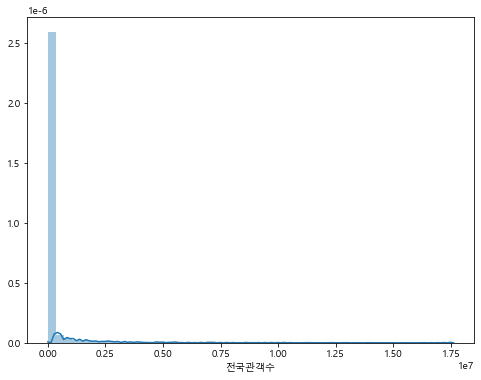

In [8]:
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_raw_data['전국관객수'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('전국관객수',movie_raw_data['전국관객수'].skew(), movie_raw_data['전국관객수'].kurt()))

In [9]:
movie_raw_data.to_csv('movie_data/movie_raw_data_fixed.csv', index = False,encoding='utf-8-sig')

# 1차로 전처리 된 데이터 (최종 관객수 만명 이상의 영화)

In [10]:
movie_data_fix1=pd.read_csv('movie_data/movie_data.csv')

# 처리된 데이터 레이블 정보
title : 영화 제목

release-time : 영화 개봉일

genre : 영화 장르

national : 영화 제작 국가

total_revenue : 전체 매출액

movie_rating : 관객 평점

num_off_screen : 전국 스크린수

screen_share : 스크린 점유율

fsd_num_off_box : 개봉 2일차 누적 관객수

num_off_box : 최종 영화 관객수

In [11]:
movie_data_fix1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1325 non-null   object 
 1   release-time     1325 non-null   object 
 2   genre            1325 non-null   object 
 3   national         1325 non-null   object 
 4   total_revenue    1325 non-null   float64
 5   movie_rating     1325 non-null   float64
 6   num_off_screen   1325 non-null   int64  
 7   screen_share     1325 non-null   float64
 8   fsd_num_off_box  1325 non-null   int64  
 9   num_off_box      1325 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 103.6+ KB


In [12]:
movie_data_fix1

,title,release-time,genre,national,total_revenue,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
0,명량,2014.7.30,사극,한국,1.360000e+11,8.44,1587,39.8,1410271,17613682
1,극한직업,2019.1.23,코미디,한국,1.400000e+11,8.50,1978,31.4,724697,16264944
2,신과함께-죄와 벌,2017.12.20,판타지,한국,1.160000e+11,7.83,1912,30.4,824013,14410754
3,국제시장,2014.12.17,드라마,한국,1.110000e+11,9.02,966,23.5,416356,14245998
4,어벤져스: 엔드게임,2019.4.24,액션,미국,1.220000e+11,9.38,2835,58.0,2171533,13934592
...,...,...,...,...,...,...,...,...,...,...
1320,폴라로이드,2019.6.6,공포(호러),미국,8.981266e+07,5.25,141,2.4,5482,10359
1321,당신에게도 사랑이 다시 찾아올까요?,2013.10.17,멜로/로맨스,미국,7.043050e+07,6.77,104,2.9,3941,10328
1322,토마스와 친구들: 우정의 대모험,2018.12.13,애니메이션,영국,7.370775e+07,8.44,196,2.7,3096,10315
1323,드래프트 데이,2014.7.10,드라마,미국,7.421620e+07,8.35,82,2.3,4108,10119


# 최종 관객수

num_off_box -> Skewness: 3.491110, Kurtosis: 15.056236


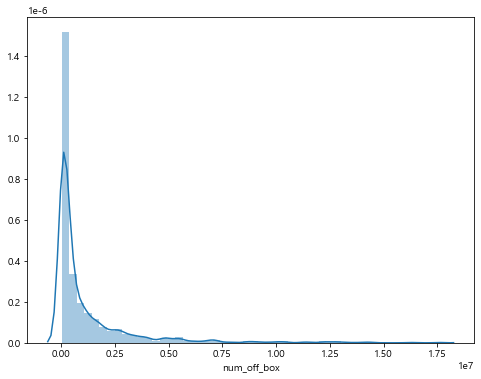

In [13]:
# 최종 관객수 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_data_fix1['num_off_box'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('num_off_box',movie_data_fix1['num_off_box'].skew(), movie_data_fix1['num_off_box'].kurt()))

# Numeric data

# 개봉 2일차 누적관객수

fsd_num_off_box -> Skewness: 3.553009, Kurtosis: 18.570440


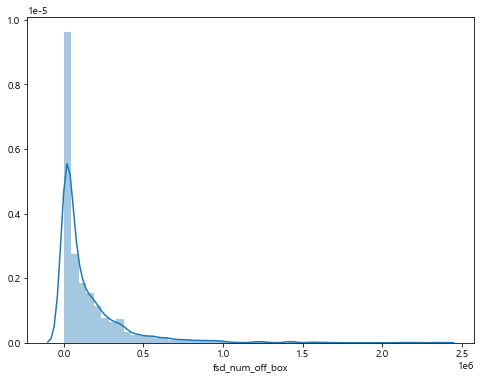

In [14]:
# 개봉 2일차 누적관객수 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_data_fix1['fsd_num_off_box'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('fsd_num_off_box',movie_data_fix1['fsd_num_off_box'].skew(), movie_data_fix1['fsd_num_off_box'].kurt()))

# 스크린 점유율

screen_share -> Skewness: 1.402762, Kurtosis: 2.988233


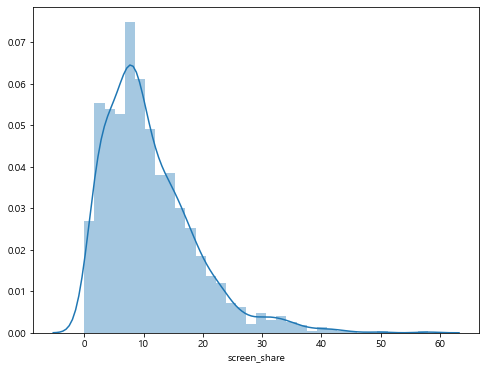

In [15]:
# 스크린 점유율 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_data_fix1['screen_share'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('screen_share',movie_data_fix1['screen_share'].skew(), movie_data_fix1['screen_share'].kurt()))

# 전국 스크린수

num_off_screen -> Skewness: 1.517136, Kurtosis: 3.306422


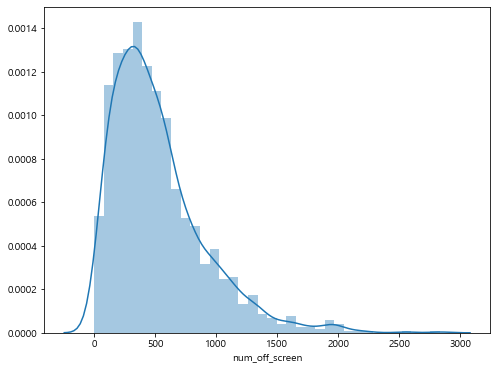

In [16]:
# 전국 스크린수 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_data_fix1['num_off_screen'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('num_off_screen',movie_data_fix1['num_off_screen'].skew(), movie_data_fix1['num_off_screen'].kurt()))

# 영화 평점

movie_rating -> Skewness: -1.165120, Kurtosis: 1.766752


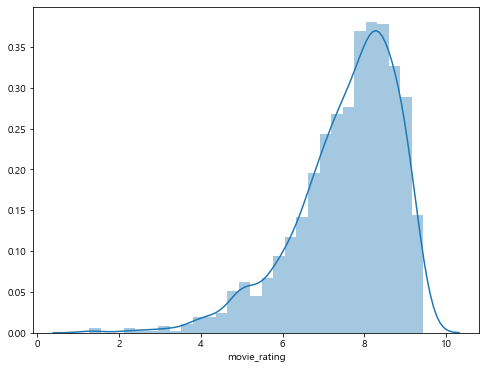

In [17]:
# 영화 평점 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(movie_data_fix1['movie_rating'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('movie_rating',movie_data_fix1['movie_rating'].skew(),movie_data_fix1['movie_rating'].kurt()))

In [18]:
movie_data_fix1

,title,release-time,genre,national,total_revenue,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
0,명량,2014.7.30,사극,한국,1.360000e+11,8.44,1587,39.8,1410271,17613682
1,극한직업,2019.1.23,코미디,한국,1.400000e+11,8.50,1978,31.4,724697,16264944
2,신과함께-죄와 벌,2017.12.20,판타지,한국,1.160000e+11,7.83,1912,30.4,824013,14410754
3,국제시장,2014.12.17,드라마,한국,1.110000e+11,9.02,966,23.5,416356,14245998
4,어벤져스: 엔드게임,2019.4.24,액션,미국,1.220000e+11,9.38,2835,58.0,2171533,13934592
...,...,...,...,...,...,...,...,...,...,...
1320,폴라로이드,2019.6.6,공포(호러),미국,8.981266e+07,5.25,141,2.4,5482,10359
1321,당신에게도 사랑이 다시 찾아올까요?,2013.10.17,멜로/로맨스,미국,7.043050e+07,6.77,104,2.9,3941,10328
1322,토마스와 친구들: 우정의 대모험,2018.12.13,애니메이션,영국,7.370775e+07,8.44,196,2.7,3096,10315
1323,드래프트 데이,2014.7.10,드라마,미국,7.421620e+07,8.35,82,2.3,4108,10119


# 데이터 각 colum 별 상관계수

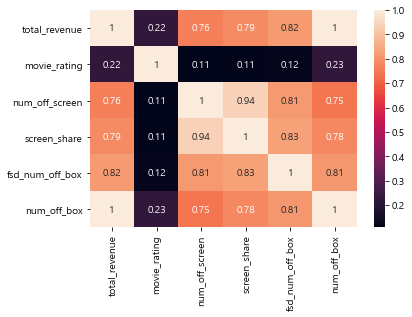

In [19]:
# 데이터 별 각 colum 별 상관계수
# 초반 이틀 누적 관객수, 스크린 점유율, 스크린수, 영화 평점순으로 중요한 특징 공간임을 알 수 있습니다.
sns.heatmap(movie_data_fix1.corr(), annot = True)

# 범주형 데이터

In [20]:
movie_data_fix1['genre'].unique()

array(['사극', '코미디', '판타지', '드라마', '액션', '어드벤처', '애니메이션', 'SF', '범죄', '전쟁',
       '미스터리', '멜로/로맨스', '스릴러', '공포(호러)', '뮤지컬', '다큐멘터리', '가족', '공연',
       '기타', '서부극(웨스턴)'], dtype=object)

In [21]:
# 한글로 명시된 장르명들을 영어로 바꾸어주는 과정
replace_name = {'사극' : 'historical_drama', '코미디' : 'comedy', '판타지' : 'fantasy', '드라마' : 'dramas',
               '액션' : 'action', '어드벤처' : 'adventure', '애니메이션' : 'animation','범죄': 'crime','전쟁': 'war','미스터리' :'mystery','멜로/로맨스' : 'melo/romance', '스릴러': 'thriller', '공포(호러)' : 'horror',
               '뮤지컬': 'musical','다큐멘터리': 'documentry','가족' : 'family','공연':'show','기타': 'others','서부극(웨스턴)' : 'western'}
movie_data_fix1.replace({'genre' : replace_name}, inplace = True)
movie_data_fix1.head()

,title,release-time,genre,national,total_revenue,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
0,명량,2014.7.30,historical_drama,한국,1.360000e+11,8.44,1587,39.8,1410271,17613682
1,극한직업,2019.1.23,comedy,한국,1.400000e+11,8.50,1978,31.4,724697,16264944
2,신과함께-죄와 벌,2017.12.20,fantasy,한국,1.160000e+11,7.83,1912,30.4,824013,14410754
3,국제시장,2014.12.17,dramas,한국,1.110000e+11,9.02,966,23.5,416356,14245998
4,어벤져스: 엔드게임,2019.4.24,action,미국,1.220000e+11,9.38,2835,58.0,2171533,13934592


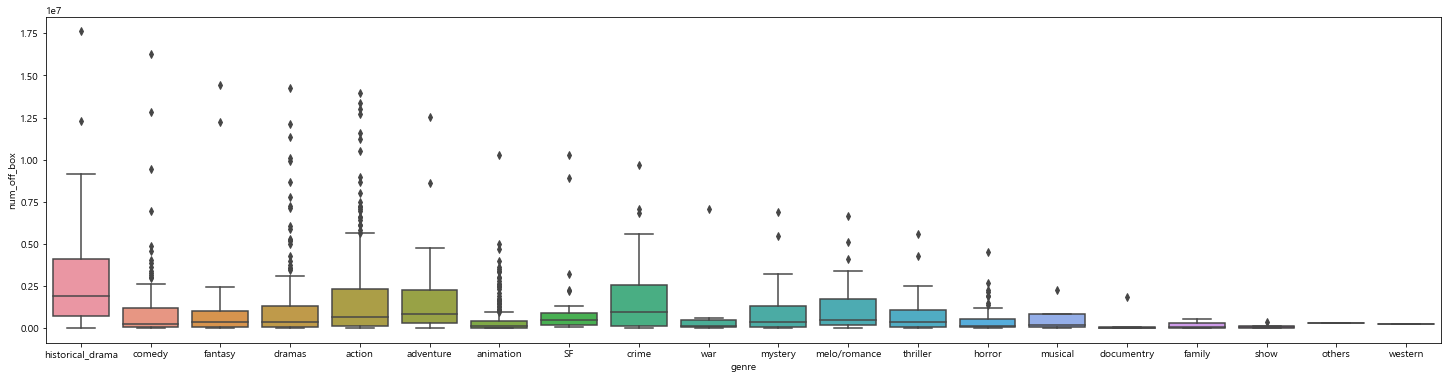

In [22]:
# 장르데이터 시각화
f, ax = plt.subplots(figsize = (25,6))
sns.boxplot(x='genre', y='num_off_box', data=movie_data_fix1[['genre', 'num_off_box']])

In [23]:
movie_data_fix1[['genre','screen_share','num_off_screen','num_off_box','fsd_num_off_box','movie_rating']].groupby('genre').mean().sort_values('num_off_box')

,screen_share,num_off_screen,num_off_box,fsd_num_off_box,movie_rating
genre,,,,,
show,2.450000,120.750000,1.119295e+05,53099.000000,9.060000
family,6.481818,308.363636,1.773730e+05,27656.818182,8.026364
western,9.900000,342.000000,2.601440e+05,51385.000000,8.530000
documentry,3.242857,163.000000,2.959676e+05,35190.285714,8.622857
others,4.300000,243.000000,3.150100e+05,118701.000000,9.320000
animation,6.896678,355.441860,4.487058e+05,49341.292359,8.028505
horror,8.101429,411.357143,4.793752e+05,76455.085714,6.315286
musical,7.225000,346.500000,6.841278e+05,133204.250000,7.677500
thriller,10.230508,482.881356,7.600463e+05,132411.406780,6.853390


In [24]:
movie_data_fix1['national'].unique()

array(['한국', '미국', '일본', '영국', '프랑스', '벨기에', '아이슬란드', '스페인', '독일',
       '남아프리카공화국', '핀란드', '중국', '인도', '러시아', '호주', '덴마크', '캐나다', '페루',
       '이탈리아', '멕시코', '뉴질랜드', '스웨덴', '태국', '터키', '체코', '홍콩', '인도네시아',
       '노르웨이', '이스라엘', '아일랜드'], dtype=object)

In [25]:
# # 한글로 명시된 국가명들을 영어로 바꾸어주는 과정
replace_name = {'한국' : 'SouthKorea', '미국' : 'America', '일본' : 'Japan', '영국':'England','프랑스': 'France',
               '벨기에' : 'Belgium', '아이슬란드' : 'Iceland', '스페인' : 'Spain','독일': 'German','남아프리카공화국': 'SouthAfrica','핀란드' :'Finland','중국' : 'China', '인도': 'India', '러시아' : 'Russia',
               '호주': 'Australia','덴마크': 'Denmark','캐나다' : 'Canada','페루':'Peru','이탈리아': 'Italy','멕시코' : 'Mexico','뉴질랜드' : 'NewZealand', '스웨덴' :'Sweden' , '태국' : 'Thailand', '터키' :'Turkey' , '체코' :'Czech' , '홍콩' :'Hongkong' , '인도네시아' :'Indonesia' ,
                '노르웨이' :'Norway' , '이스라엘' : 'Israel', '아일랜드' :'Ireland'}
movie_data_fix1.replace({'national' : replace_name}, inplace = True)
movie_data_fix1.head()

,title,release-time,genre,national,total_revenue,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
0,명량,2014.7.30,historical_drama,SouthKorea,1.360000e+11,8.44,1587,39.8,1410271,17613682
1,극한직업,2019.1.23,comedy,SouthKorea,1.400000e+11,8.50,1978,31.4,724697,16264944
2,신과함께-죄와 벌,2017.12.20,fantasy,SouthKorea,1.160000e+11,7.83,1912,30.4,824013,14410754
3,국제시장,2014.12.17,dramas,SouthKorea,1.110000e+11,9.02,966,23.5,416356,14245998
4,어벤져스: 엔드게임,2019.4.24,action,America,1.220000e+11,9.38,2835,58.0,2171533,13934592


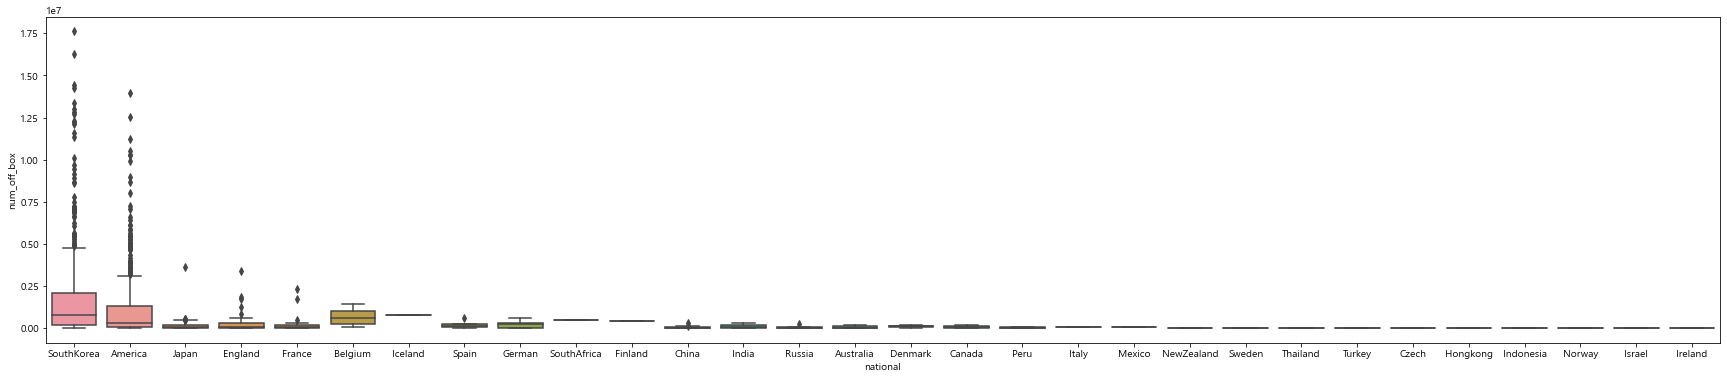

In [26]:
f, ax = plt.subplots(figsize = (30,6))
sns.boxplot(x='national', y='num_off_box', data=movie_data_fix1[['national', 'num_off_box']])

In [27]:
movie_data_fix1[['national','genre','screen_share','num_off_screen','num_off_box','fsd_num_off_box','movie_rating']].groupby('national').mean().sort_values('num_off_box')

,screen_share,num_off_screen,num_off_box,fsd_num_off_box,movie_rating
national,,,,,
Ireland,2.200000,129.000000,1.222000e+04,700.000000,6.530000
Israel,3.200000,142.000000,1.474600e+04,2722.000000,6.170000
Hongkong,3.633333,156.000000,1.569033e+04,6999.333333,7.166667
Norway,4.150000,203.000000,1.687600e+04,1479.500000,7.795000
Indonesia,3.800000,120.000000,2.170500e+04,8387.000000,7.850000
Czech,5.400000,354.000000,2.527800e+04,4165.000000,7.570000
Turkey,5.000000,320.000000,2.712800e+04,6207.000000,4.530000
Thailand,2.200000,104.000000,2.746300e+04,2374.000000,8.540000
NewZealand,1.066667,62.666667,3.118233e+04,8705.333333,9.330000


In [28]:
movie_data_fix1.to_csv('movie_data_fixed_english.csv', index = False,encoding='utf-8-sig')

# 최종 전처리 데이터

In [29]:
movie_data=pd.read_csv('movie_data/movie_data_fixed_final.csv')

In [30]:
movie_data.head()

,title,release-time,genre,historical_drama,adventure,action,crime,fantasy,war,drama,...,korea,america,japan,others,national,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
0,명량,0,historical_drama,1,0,0,0,0,0,0,...,1,0,0,0,SouthKorea,8.44,1587,39.8,1410271,17613682
1,극한직업,1,comedy,0,0,0,0,0,0,0,...,1,0,0,0,SouthKorea,8.50,1978,31.4,724697,16264944
2,신과함께-죄와 벌,0,fantasy,0,0,0,0,1,0,0,...,1,0,0,0,SouthKorea,7.83,1912,30.4,824013,14410754
3,국제시장,0,dramas,0,0,0,0,0,0,1,...,1,0,0,0,SouthKorea,9.02,966,23.5,416356,14245998
4,어벤져스: 엔드게임,0,action,0,0,1,0,0,0,0,...,0,1,0,0,America,9.38,2835,58.0,2171533,13934592


# 최종 처리된 데이터 레이블 정보

release-time : 개봉일 기준 2주 이내에 추석이나 설이 있는 경우 1 아니면 0

genre : 장르

historical_drama : 장르가 사극인 경우

adventure : 장르가 어드벤쳐인 경우

historical_drama ~show : 장르가 사극 ~ 공연

korea : 국가가 한국인 경우

america : 국가가 미국인 경우

japan : 국가가 일본인 경우

others : 국가가 그외인 경우

national : 국가

movie_rating :영화 평점

num_off_screnn : 전국 스크린수

screen_share : 스크린 점유율

fsd_num_off_box : 개봉 2일차 누적 관객수

num_off_box : 최종 관객수


In [31]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             1325 non-null   object 
 1   release-time      1325 non-null   int64  
 2   genre             1325 non-null   object 
 3   historical_drama  1325 non-null   int64  
 4   adventure         1325 non-null   int64  
 5   action            1325 non-null   int64  
 6   crime             1325 non-null   int64  
 7   fantasy           1325 non-null   int64  
 8   war               1325 non-null   int64  
 9   drama             1325 non-null   int64  
 10  comedy            1325 non-null   int64  
 11  SF                1325 non-null   int64  
 12  melo/romance      1325 non-null   int64  
 13  mystery           1325 non-null   int64  
 14  thriller          1325 non-null   int64  
 15  musical           1325 non-null   int64  
 16  horror            1325 non-null   int64  


In [32]:
# 결측치 확인
movie_data.isna().sum() / 600

title               0.0
release-time        0.0
genre               0.0
historical_drama    0.0
adventure           0.0
action              0.0
crime               0.0
fantasy             0.0
war                 0.0
drama               0.0
comedy              0.0
SF                  0.0
melo/romance        0.0
mystery             0.0
thriller            0.0
musical             0.0
horror              0.0
animation           0.0
documentry          0.0
western             0.0
family              0.0
show                0.0
korea               0.0
america             0.0
japan               0.0
others              0.0
national            0.0
movie_rating        0.0
num_off_screen      0.0
screen_share        0.0
fsd_num_off_box     0.0
num_off_box         0.0
dtype: float64

In [33]:
movie_data.describe()

,release-time,historical_drama,adventure,action,crime,fantasy,war,drama,comedy,SF,...,show,korea,america,japan,others,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
count,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,...,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1.325000e+03,1.325000e+03
mean,0.089811,0.021132,0.021887,0.216604,0.054340,0.024151,0.004528,0.141132,0.076226,0.028679,...,0.003774,0.353208,0.443774,0.140377,0.062642,7.574415,523.730566,10.981208,1.549131e+05,1.162041e+06
std,0.286019,0.143879,0.146369,0.412086,0.226772,0.153576,0.067165,0.348289,0.265460,0.166966,...,0.061337,0.478147,0.497016,0.347509,0.242409,1.254508,383.697236,7.677534,2.408750e+05,2.127589e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.270000,1.000000,0.000000,2.990000e+02,1.009400e+04
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.910000,251.000000,5.500000,1.670000e+04,6.607400e+04
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.840000,435.000000,9.200000,6.001000e+04,3.109560e+05
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,8.480000,691.000000,14.900000,1.977510e+05,1.221420e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.440000,2835.000000,58.000000,2.346364e+06,1.761368e+07


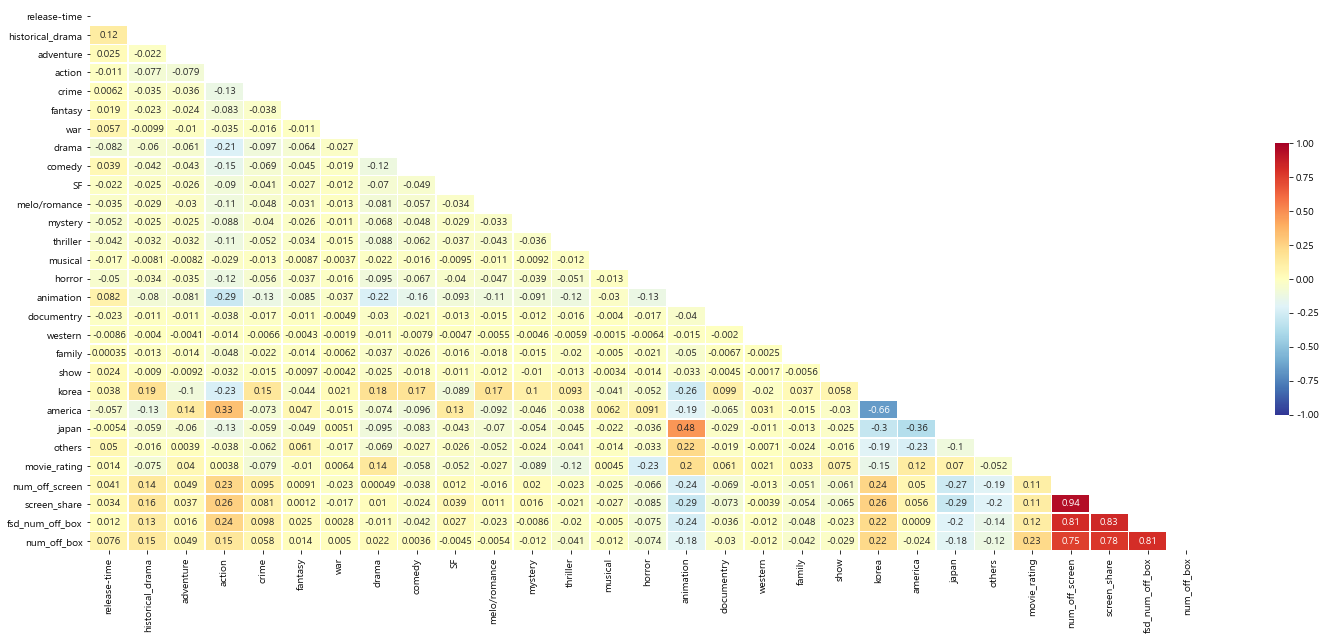

In [34]:
fig, ax = plt.subplots(figsize=(25,10))
mask = np.zeros_like(movie_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(movie_data.corr(), cmap = 'RdYlBu_r', annot = True, mask=mask,linewidths=.5,cbar_kws={"shrink": .5},vmin = -1,vmax = 1)  
plt.show()


# train 데이터와 test 데이터로 분리 (train 80%, test 20% ,랜덤 샘플링)

In [35]:
# shuffle = True
movie_data_train, movie_data_test= train_test_split(movie_data,test_size=0.2,shuffle=True,random_state=1004)

In [36]:
movie_data_train.shape

(1060, 32)

In [37]:
movie_data_test.shape

(265, 32)

In [38]:
movie_data_train.head()

,title,release-time,genre,historical_drama,adventure,action,crime,fantasy,war,drama,...,korea,america,japan,others,national,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
1324,폴라로이드,0,dramas,0,0,0,0,0,0,1,...,1,0,0,0,SouthKorea,6.51,27,0.6,6084,10094
409,더 킹,1,crime,0,0,0,1,0,0,0,...,1,0,0,0,SouthKorea,8.09,1310,22.2,541017,905885
962,엑스 마키나,0,SF,0,0,0,0,0,0,0,...,0,1,0,0,America,7.61,207,4.3,17707,78049
9,알라딘,0,adventure,0,1,0,0,0,0,0,...,0,1,0,0,America,9.38,1311,19.9,185003,12552283
1118,몬스터 왕국,0,animation,0,0,0,0,0,0,0,...,0,0,1,0,Sweden,6.23,160,3.8,7226,34888


In [39]:
movie_data_test.head()

,title,release-time,genre,historical_drama,adventure,action,crime,fantasy,war,drama,...,korea,america,japan,others,national,movie_rating,num_off_screen,screen_share,fsd_num_off_box,num_off_box
162,메이즈 러너: 스코치 트라이얼,1,action,0,0,1,0,0,0,0,...,0,1,0,0,America,8.07,804,19.8,237867,2744413
1018,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,0,animation,0,0,0,0,0,0,0,...,0,0,1,0,Japan,8.15,191,3.3,21458,56539
131,스타워즈: 깨어난 포스,0,action,0,0,1,0,0,0,0,...,0,1,0,0,America,7.75,940,22.4,338231,3273879
1081,약장수,0,dramas,0,0,0,0,0,0,1,...,1,0,0,0,SouthKorea,8.61,282,7.2,11942,43562
356,헝거게임: 캣칭 파이어,0,fantasy,0,0,0,0,1,0,0,...,0,1,0,0,America,8.33,630,16.7,170752,1125739


In [40]:
movie_data_test.to_csv('movie_data/movie_data_test.csv', index = False, encoding='cp949')
show_test_data=pd.read_csv('movie_data/movie_data_test_show.csv',encoding='cp949')

# 모델링 
(특징공간 : 관객 평점 , 전국 스크린수, 스크린 점유율, 초반 이틀 누적 관객수, 범주형 자료인 (장르, 국가)

LinearRegression

lightgbm

XGBOOST

RandomForest


In [41]:
model_linear = LinearRegression()
model_lgbm = lgb.LGBMRegressor(random_state=777, n_estimators=1000)
model_xgb = xgb.XGBRegressor(random_state=777, n_estimators=1000)
model_rf = RandomForestRegressor(random_state=777, n_estimators=1000)

In [42]:
# 특징공간 설정
features = ['movie_rating', 'num_off_screen', 'screen_share', 'fsd_num_off_box','korea','america','japan','others','release-time','historical_drama','adventure','action','crime','fantasy','war','drama','comedy','SF','melo/romance','mystery','thriller','musical','horror','animation','documentry',	'western',	'family',	'show']
target = ['num_off_box']

In [43]:
x_train, x_test, y_train =movie_data_train[features], movie_data_test[features], movie_data_train[target]

In [44]:
# 모델링
model_linear.fit(x_train, y_train) # // LinerRegression
model_lgbm.fit(x_train, y_train)   # // Lightgbm
model_xgb.fit(x_train, y_train)     # // XGB
model_rf.fit(x_train, y_train)     # // RandomForest

<ipython-input-44-e6b4fa20f3d6>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(x_train, y_train)     # // RandomForest


RandomForestRegressor(n_estimators=1000, random_state=777)

In [45]:
singleLR = show_test_data.copy()
singleLGBM = show_test_data.copy()
singleXGB = show_test_data.copy()
singleRF = show_test_data.copy()

In [46]:
# 테스트 데이터 모델에 적용
singleLR['num_off_box'] = model_linear.predict(x_test)
singleLGBM['num_off_box'] =model_lgbm.predict(x_test)
singleXGB['num_off_box'] = model_xgb.predict(x_test)
singleRF['num_off_box'] = model_rf.predict(x_test)

# 모델들의 mse rmse 결정계수

In [47]:
# 모델들의 mse rmse 결정계수

#LinerRegression
print("LinerRegression")
print('LinerRegression 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], singleLR['num_off_box']))
print('LinerRegression 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], singleLR['num_off_box'])**0.5)
print("LinerRegression 모델의 결정계수 =",r2_score(movie_data_test['num_off_box'], singleLR['num_off_box']))
print("")
#Lightgbm
print("Lightgbm")
print('Lightgbm 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], singleLGBM['num_off_box']))
print('Lightgbm 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], singleLGBM['num_off_box'])**0.5)
print("Lightgbm 모델의 결정계수 =" ,r2_score(movie_data_test['num_off_box'], singleLGBM['num_off_box']))
print("")
#XGB
print("XGB")
print('XGB 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], singleXGB['num_off_box']))
print('XGB 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], singleXGB['num_off_box'])**0.5)
print("XGB 모델의 결정계수 =", r2_score(movie_data_test['num_off_box'], singleXGB['num_off_box']))
print("")
#RandomForest
print("RandomForest")
print('RandomForest 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], singleRF['num_off_box']))
print('RandomForest 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], singleRF['num_off_box'])**0.5)
print("RandomForest 모델의 결정계수 = ",r2_score(movie_data_test['num_off_box'], singleRF['num_off_box']))
print("")

LinerRegression
LinerRegression 모델의 Mean_Squared_Error =  635578289415.2357
LinerRegression 모델의 RMSE =  797231.6410023097
LinerRegression 모델의 결정계수 = 0.7904912697738412

Lightgbm
Lightgbm 모델의 Mean_Squared_Error =  535777211421.58704
Lightgbm 모델의 RMSE =  731968.0398908049
Lightgbm 모델의 결정계수 = 0.8233891794001891

XGB
XGB 모델의 Mean_Squared_Error =  626982230332.7844
XGB 모델의 RMSE =  791822.0951279298
XGB 모델의 결정계수 = 0.79332483009726

RandomForest
RandomForest 모델의 Mean_Squared_Error =  457921099219.44366
RandomForest 모델의 RMSE =  676698.6768270229
RandomForest 모델의 결정계수 =  0.8490532643437195



In [48]:
singleLR

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,2.595008e+06
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,-1.050971e+04
2,스타워즈: 깨어난 포스,action,America,2.914215e+06
3,약장수,dramas,SouthKorea,4.227718e+05
4,헝거게임: 캣칭 파이어,fantasy,America,1.961248e+06
...,...,...,...,...
260,범죄도시,crime,SouthKorea,3.988801e+06
261,빅뱅 메이드,documentry,SouthKorea,2.743677e+04
262,그레이의 50가지 그림자,dramas,America,5.564340e+05
263,블랙 팬서,action,America,7.494303e+06


In [49]:
singleLGBM

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,1.784199e+06
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,1.595314e+05
2,스타워즈: 깨어난 포스,action,America,1.795713e+06
3,약장수,dramas,SouthKorea,1.170576e+05
4,헝거게임: 캣칭 파이어,fantasy,America,2.000151e+06
...,...,...,...,...
260,범죄도시,crime,SouthKorea,8.249927e+06
261,빅뱅 메이드,documentry,SouthKorea,-3.304525e+04
262,그레이의 50가지 그림자,dramas,America,5.556553e+05
263,블랙 팬서,action,America,5.220425e+06


In [50]:
singleXGB

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,2.458652e+06
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,2.119584e+05
2,스타워즈: 깨어난 포스,action,America,2.323735e+06
3,약장수,dramas,SouthKorea,1.739542e+05
4,헝거게임: 캣칭 파이어,fantasy,America,1.719043e+06
...,...,...,...,...
260,범죄도시,crime,SouthKorea,9.115255e+06
261,빅뱅 메이드,documentry,SouthKorea,2.660953e+04
262,그레이의 50가지 그림자,dramas,America,5.568878e+05
263,블랙 팬서,action,America,6.239690e+06


In [51]:
singleRF

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,2776414.765
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,150934.627
2,스타워즈: 깨어난 포스,action,America,2458185.102
3,약장수,dramas,SouthKorea,82777.398
4,헝거게임: 캣칭 파이어,fantasy,America,1985394.207
...,...,...,...,...
260,범죄도시,crime,SouthKorea,8289540.792
261,빅뱅 메이드,documentry,SouthKorea,69803.926
262,그레이의 50가지 그림자,dramas,America,554214.489
263,블랙 팬서,action,America,6804521.082


# XGBoostRegressor + BayesianOptimization

In [52]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.0001, 0.4),
            'n_estimators': (10, 1000),
            'max_depth': (3,10),   
            'subsample': (0.5, 1),  
            'colsample_bytree': (0.5, 1),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    
    params = {
        'learning_rate': learning_rate,                      # 학습률
        'n_estimators' : int(round(n_estimators)),           # 생성할 tree의 갯수
        'max_depth' : int(round(max_depth)),                 # 최대 깊이
        'subsample': subsample,                              # 각 트리마다의 관측 데이터 샘플링 비율
        'colsample': colsample_bytree,                       # 각 트리마다의 feature 샘플링 비율
        'gamma': gamma,                                      # 분할을 수행하는데 필요한 최소 손실 감소
        'n_jobs' : -1,                                       # 사용할 cpu 갯수( -1 있는거 다 사용)
        'random_state' : 777                                 # 랜덤 샘플링시 고정할 시드 값
    }
    
    m_xgb = xgb.XGBRegressor(**params)
    
    kf = KFold(n_splits = 5 , shuffle=True, random_state=50)

    score = cross_val_score(m_xgb, x_train, y_train, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [53]:
BO_xgb.maximize(init_points = 10, n_iter = 100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -1.172e+1 |  0.7744   |  3.576    |  0.2411   |  6.814    |  429.4    |  0.8229   |
|  2        | -1.303e+1 |  0.7188   |  4.459    |  0.3855   |  5.684    |  793.8    |  0.7644   |
|  3        | -2.362e+1 |  0.784    |  4.628    |  0.02851  |  3.61     |  30.02    |  0.9163   |
|  4        | -1.485e+1 |  0.8891   |  4.35     |  0.3914   |  8.594    |  466.9    |  0.8903   |
|  5        | -1.143e+1 |  0.5591   |  3.2      |  0.05743  |  9.613    |  526.6    |  0.7073   |
|  6        | -1.171e+1 |  0.6323   |  3.871    |  0.1825   |  6.979    |  28.6     |  0.8088   |
|  7        | -1.255e+1 |  0.806    |  3.085    |  0.3775   |  7.773    |  365.9    |  0.7185   |
|  8        | -1.21e+12 |  0.8488   |  0.3011   |  0.2667   |  7.694    |  218.3    |  0.5645   |
|  9        | -1.134

|  51       | -1.071e+1 |  0.9778   |  2.854    |  0.09423  |  3.171    |  424.5    |  0.7539   |
|  52       | -1.242e+1 |  0.9508   |  2.954    |  0.2099   |  6.357    |  808.8    |  0.9693   |
|  53       | -1.31e+12 |  0.5435   |  3.354    |  0.153    |  8.749    |  824.4    |  0.9266   |
|  54       | -1.203e+1 |  0.5314   |  2.793    |  0.04949  |  8.447    |  826.1    |  0.8195   |
|  55       | -1.194e+1 |  0.7347   |  0.4609   |  0.1768   |  9.702    |  530.6    |  0.7509   |
|  56       | -1.323e+1 |  0.6326   |  1.772    |  0.248    |  6.358    |  853.4    |  0.8869   |
|  57       | -1.279e+1 |  0.7255   |  3.821    |  0.3667   |  7.328    |  482.1    |  0.6121   |
|  58       | -1.19e+12 |  0.6505   |  3.637    |  0.3586   |  5.197    |  716.6    |  0.6423   |
|  59       | -1.293e+1 |  0.9102   |  2.483    |  0.01012  |  6.92     |  303.1    |  0.8884   |
|  60       | -1.202e+1 |  0.7459   |  4.32     |  0.1787   |  7.116    |  621.3    |  0.8459   |
|  61       | -1.215

|  102      | -1.254e+1 |  0.9627   |  3.993    |  0.06622  |  6.533    |  405.8    |  0.8894   |
|  103      | -1.137e+1 |  0.5499   |  0.7784   |  0.1716   |  4.159    |  439.3    |  0.6607   |
|  104      | -1.15e+12 |  0.7266   |  1.311    |  0.04109  |  6.031    |  896.7    |  0.721    |
|  105      | -1.11e+12 |  0.749    |  4.206    |  0.2247   |  5.411    |  417.2    |  0.5792   |
|  106      | -1.381e+1 |  0.6241   |  4.461    |  0.38     |  7.937    |  148.5    |  0.6827   |
|  107      | -1.082e+1 |  0.6074   |  0.1722   |  0.06266  |  9.04     |  918.4    |  0.5544   |
|  108      | -1.306e+1 |  0.6143   |  2.46     |  0.3953   |  4.499    |  191.6    |  0.7605   |
|  109      | -1.213e+1 |  0.522    |  3.492    |  0.3763   |  4.05     |  150.4    |  0.7801   |
|  110      | -1.164e+1 |  0.8509   |  0.886    |  0.2973   |  6.652    |  290.0    |  0.6633   |


In [54]:
BO_xgb.max

{'target': -1061599499599.6699,
 'params': {'colsample_bytree': 0.7622323087547037,
  'gamma': 4.668891654884576,
  'learning_rate': 0.0799426516186475,
  'max_depth': 4.633081788197476,
  'n_estimators': 881.5694627831114,
  'subsample': 0.7463609410494453}}

In [55]:
params = BO_xgb.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

In [56]:
final_xgb=xgb.XGBRegressor(random_state = 777, **params)
final_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7622323087547037,
             gamma=4.668891654884576, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0799426516186475,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=882, n_jobs=8,
             num_parallel_tree=1, random_state=777, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7463609410494453,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
finalxgb = show_test_data.copy()
finalxgb['num_off_box'] = final_xgb.predict(x_test)

In [58]:
print('파라미터 조정후 XGB 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], finalxgb['num_off_box']))
print('파라미터 조정후 XGB 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], finalxgb['num_off_box'])**0.5)
print("파라미터 조정후 XGB 모델의 결정계수 =", r2_score(movie_data_test['num_off_box'], finalxgb['num_off_box']))

파라미터 조정후 XGB 모델의 Mean_Squared_Error =  439073119270.50684
파라미터 조정후 XGB 모델의 RMSE =  662625.9271040538
파라미터 조정후 XGB 모델의 결정계수 = 0.8552662146791739


# LGBMRegressor + BayesianOptimization

In [59]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (10, 1000),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'colsample_bytree': (0.5,1),   
            'num_leaves': (2,16),
            'min_child_weight': (1, 10)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,               # 학습률
        'n_estimators' : int(round(n_estimators)),    # 생성할 tree의 갯수
        'max_depth' : int(round(max_depth)),          # 최대 깊이
        'subsample': subsample,                       # 각 트리마다의 관측 데이터 샘플링 비율
        'colsample_bytree' : colsample_bytree,        # 각 트리마다의 feature 샘플링 비율
        'num_leaves' : int(round(num_leaves)),        # 노드의 개수
        'min_child_weight' : min_child_weight,        # child의 관측에서 요구되는 최소 가중치의 합
        'n_jobs' : -1                                 # cpu 사용 개수 (-1 이면 있는거 다 사용)
    }
    
    m_lgb = lgb.LGBMRegressor(**params)
    
    kf = KFold(n_splits=5 , shuffle=True, random_state=50)

    score = cross_val_score(m_lgb, x_train, y_train, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)  

In [60]:
BO_lgbm.maximize(init_points=10, n_iter = 100)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.212e+1 |  0.7085   |  0.1442   |  3.001    |  3.721    |  155.3    |  3.293    |  0.5931   |
|  2        | -1.174e+1 |  0.6728   |  0.07966  |  6.772    |  4.773    |  688.4    |  4.862    |  0.9391   |
|  3        | -1.208e+1 |  0.5137   |  0.1343   |  5.921    |  6.028    |  149.0    |  4.773    |  0.9004   |
|  4        | -1.203e+1 |  0.9841   |  0.06303  |  7.846    |  8.888    |  895.7    |  3.191    |  0.5195   |
|  5        | -1.3e+12  |  0.5849   |  0.1757   |  3.688    |  4.79     |  958.3    |  9.464    |  0.8459   |
|  6        | -1.303e+1 |  0.6578   |  0.1375   |  8.842    |  1.165    |  752.6    |  15.84    |  0.8741   |
|  7        | -1.26e+12 |  0.6402   |  0.158    |  3.723    |  5.031    |  909.5    |  6.111    |  0.6439   |
|  8      

|  45       | -2.576e+1 |  0.9013   |  0.003962 |  5.149    |  5.37     |  144.6    |  9.998    |  0.583    |
|  46       | -1.291e+1 |  0.9067   |  0.1716   |  5.977    |  4.817    |  693.7    |  6.776    |  0.7885   |
|  47       | -3.422e+1 |  0.5      |  0.0005   |  3.739    |  5.082    |  686.9    |  5.823    |  1.0      |
|  48       | -1.187e+1 |  0.7781   |  0.1073   |  8.362    |  5.147    |  150.9    |  5.637    |  0.8298   |
|  49       | -1.166e+1 |  0.7331   |  0.1349   |  5.014    |  4.62     |  150.5    |  7.94     |  0.9025   |
|  50       | -1.288e+1 |  0.5      |  0.2      |  5.104    |  6.452    |  691.4    |  7.194    |  0.5      |
|  51       | -1.163e+1 |  0.9856   |  0.08466  |  5.534    |  9.242    |  149.6    |  3.855    |  0.7431   |
|  52       | -1.144e+1 |  0.9913   |  0.1944   |  8.482    |  7.372    |  148.1    |  5.487    |  0.5319   |
|  53       | -1.247e+1 |  0.5477   |  0.08528  |  8.136    |  7.456    |  689.1    |  7.468    |  0.6555   |
|  54     

|  90       | -1.192e+1 |  0.754    |  0.12     |  9.822    |  8.943    |  150.5    |  5.823    |  0.9247   |
|  91       | -1.264e+1 |  1.0      |  0.2      |  6.743    |  10.0     |  150.3    |  9.502    |  1.0      |
|  92       | -1.205e+1 |  0.7603   |  0.04503  |  6.085    |  6.292    |  517.0    |  15.35    |  0.5421   |
|  93       | -3.682e+1 |  0.5      |  0.0005   |  7.918    |  8.752    |  514.7    |  16.0     |  1.0      |
|  94       | -1.213e+1 |  0.9743   |  0.08292  |  4.388    |  7.394    |  518.6    |  12.97    |  0.9002   |
|  95       | -1.259e+1 |  0.5      |  0.2      |  8.224    |  1.0      |  696.3    |  9.895    |  0.5      |
|  96       | -1.353e+1 |  1.0      |  0.2      |  7.134    |  9.277    |  518.2    |  11.2     |  0.8841   |
|  97       | -1.271e+1 |  0.5832   |  0.1839   |  8.222    |  5.301    |  687.7    |  10.68    |  0.6569   |
|  98       | -1.175e+1 |  0.9306   |  0.05311  |  3.813    |  1.822    |  145.8    |  15.67    |  0.8935   |
|  99     

In [61]:
BO_lgbm.max

{'target': -1143814140760.9097,
 'params': {'colsample_bytree': 0.9912664767877215,
  'learning_rate': 0.19443159578980238,
  'max_depth': 8.481756199865636,
  'min_child_weight': 7.3717217915267526,
  'n_estimators': 148.1347345645211,
  'num_leaves': 5.4870988863479955,
  'subsample': 0.5319290011403701}}

In [62]:
params = BO_lgbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['num_leaves'] = int(round(params['num_leaves']))

In [63]:
final_lgb=lgb.LGBMRegressor(random_state=777, **params)
final_lgb.fit(x_train, y_train)
finallgb = show_test_data.copy()
finallgb['num_off_box'] = final_lgb.predict(x_test)

In [64]:
print('파라미터 조정후 lgb 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], finallgb['num_off_box']))
print('파라미터 조정후 lgb 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], finallgb['num_off_box'])**0.5)
print("파라미터 조정후 lgb 모델의 결정계수 =", r2_score(movie_data_test['num_off_box'], finallgb['num_off_box']))

파라미터 조정후 lgb 모델의 Mean_Squared_Error =  542290670108.6666
파라미터 조정후 lgb 모델의 RMSE =  736403.8770326149
파라미터 조정후 lgb 모델의 결정계수 = 0.8212421166674986


#  GradientBoostingRegressor + BayesianOptimization



In [65]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (10, 500),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}

def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingRegressor(**params)
    kf = KFold(n_splits = 5 , shuffle = True, random_state=50)
    score = cross_val_score(gbm, x_train, y_train, scoring='neg_mean_squared_error', cv = kf, n_jobs=-1)
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    

In [66]:
BO_gbm.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -1.184e+1 |  0.11     |  8.006    |  3.411    |  3.635    |  217.6    |  0.8229   |
|  2        | -1.125e+1 |  0.0878   |  9.242    |  4.855    |  3.15     |  397.9    |  0.7644   |
|  3        | -1.466e+1 |  0.1138   |  9.479    |  1.284    |  2.261    |  19.91    |  0.9163   |
|  4        | -1.099e+1 |  0.1557   |  9.09     |  4.914    |  4.397    |  236.1    |  0.8903   |
|  5        | -1.15e+12 |  0.0241   |  7.479    |  1.573    |  4.834    |  265.7    |  0.7073   |
|  6        | -1.65e+12 |  0.05328  |  8.42     |  2.825    |  3.705    |  19.21    |  0.8088   |
|  7        | -1.125e+1 |  0.1226   |  7.319    |  4.775    |  4.045    |  186.2    |  0.7185   |
|  8        | -1.077e+1 |  0.1397   |  3.422    |  3.667    |  4.012    |  113.1    |  0.5645   |
|  9        | -1.085

|  51       | -1.053e+1 |  0.115    |  4.706    |  4.525    |  4.34     |  251.7    |  0.7749   |
|  52       | -1.081e+1 |  0.199    |  6.546    |  4.75     |  4.858    |  256.9    |  0.5754   |
|  53       | -3.586e+1 |  0.000896 |  8.455    |  1.48     |  2.231    |  255.3    |  0.9968   |
|  54       | -1.095e+1 |  0.09158  |  3.396    |  4.089    |  4.451    |  247.6    |  0.6921   |
|  55       | -1.172e+1 |  0.2      |  3.0      |  5.0      |  5.0      |  259.3    |  0.5      |
|  56       | -1.193e+1 |  0.2      |  3.719    |  5.0      |  5.0      |  265.0    |  0.5      |
|  57       | -1.188e+1 |  0.1567   |  5.29     |  3.145    |  2.202    |  269.5    |  0.9074   |
|  58       | -1.177e+1 |  0.08684  |  3.074    |  1.077    |  2.43     |  235.8    |  0.7127   |
|  59       | -4.097e+1 |  0.0005   |  3.0      |  1.0      |  2.0      |  264.9    |  1.0      |
|  60       | -1.084e+1 |  0.1186   |  7.825    |  4.943    |  4.734    |  268.7    |  0.6901   |
|  61       | -1.144

|  102      | -1.143e+1 |  0.02718  |  3.004    |  1.251    |  2.779    |  171.9    |  0.7543   |
|  103      | -1.113e+1 |  0.09141  |  3.262    |  4.629    |  2.547    |  122.6    |  0.9722   |
|  104      | -1.187e+1 |  0.1387   |  3.293    |  1.396    |  3.021    |  191.8    |  0.8009   |
|  105      | -1.115e+1 |  0.2      |  3.0      |  5.0      |  5.0      |  193.5    |  0.5      |
|  106      | -1.206e+1 |  0.06508  |  9.961    |  1.748    |  2.082    |  496.4    |  0.7855   |
|  107      | -1.157e+1 |  0.02529  |  8.461    |  1.807    |  4.803    |  186.1    |  0.5828   |
|  108      | -1.163e+1 |  0.1993   |  6.852    |  4.727    |  4.67     |  261.9    |  0.8412   |
|  109      | -1.08e+12 |  0.02495  |  3.198    |  3.735    |  4.833    |  255.4    |  0.5303   |
|  110      | -1.138e+1 |  0.09884  |  3.102    |  4.604    |  4.404    |  398.4    |  0.7096   |
|  111      | -1.135e+1 |  0.1072   |  3.009    |  1.713    |  2.207    |  117.7    |  0.9423   |
|  112      | -1.235

|  153      | -1.158e+1 |  0.1825   |  3.006    |  1.344    |  4.569    |  251.2    |  0.8496   |
|  154      | -1.244e+1 |  0.1388   |  9.532    |  1.779    |  2.021    |  395.4    |  0.8311   |
|  155      | -1.128e+1 |  0.1663   |  8.879    |  4.978    |  2.294    |  277.7    |  0.6548   |
|  156      | -1.202e+1 |  0.2      |  4.293    |  5.0      |  2.0      |  277.6    |  0.5      |
|  157      | -1.138e+1 |  0.1917   |  7.861    |  4.688    |  4.082    |  281.7    |  0.9742   |
|  158      | -1.437e+1 |  0.2      |  6.628    |  1.268    |  2.0      |  280.7    |  0.5      |
|  159      | -1.38e+12 |  0.1185   |  3.243    |  1.222    |  4.966    |  483.8    |  0.5308   |
|  160      | -1.192e+1 |  0.2      |  3.221    |  5.0      |  5.0      |  281.6    |  1.0      |
|  161      | -4.022e+1 |  0.0005   |  5.243    |  5.0      |  2.664    |  285.5    |  0.5      |
|  162      | -1.149e+1 |  0.09914  |  9.838    |  4.99     |  2.158    |  178.8    |  0.9765   |
|  163      | -1.228

|  204      | -1.165e+1 |  0.06678  |  7.191    |  3.96     |  4.689    |  98.16    |  0.6295   |
|  205      | -1.101e+1 |  0.0505   |  3.08     |  3.894    |  4.879    |  235.3    |  0.7892   |
|  206      | -3.304e+1 |  0.001667 |  9.515    |  4.901    |  2.082    |  174.2    |  0.5126   |
|  207      | -1.065e+1 |  0.112    |  6.231    |  4.847    |  4.871    |  88.88    |  0.6955   |
|  208      | -1.148e+1 |  0.05848  |  9.96     |  4.04     |  4.801    |  207.1    |  0.6391   |
|  209      | -1.165e+1 |  0.1913   |  7.535    |  4.43     |  2.049    |  92.0     |  0.5863   |
|  210      | -1.407e+1 |  0.1309   |  9.344    |  1.247    |  4.856    |  112.0    |  0.9003   |


In [67]:
BO_gbm.max

{'target': -1037174811024.0879,
 'params': {'learning_rate': 0.030557011409722508,
  'max_depth': 3.9429737098421787,
  'min_samples_leaf': 3.22187220977282,
  'min_samples_split': 2.6134814238850232,
  'n_estimators': 232.84243392359306,
  'subsample': 0.6107963560307076}}

In [68]:
params = BO_gbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['min_samples_leaf'] = int(round(params['min_samples_leaf']))
params['min_samples_split'] = int(round(params['min_samples_split']))

In [69]:
gbm = GradientBoostingRegressor(random_state = 777, **params)
gbm.fit(x_train, y_train)
finalgbm = show_test_data.copy()
finalgbm['num_off_box'] = gbm.predict(x_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [70]:
print('파라미터 조정후 lgb 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], finalgbm['num_off_box']))
print('파라미터 조정후 lgb 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], finalgbm['num_off_box'])**0.5)
print("파라미터 조정후 lgb 모델의 결정계수 =", r2_score(movie_data_test['num_off_box'], finalgbm['num_off_box']))

파라미터 조정후 lgb 모델의 Mean_Squared_Error =  432870950787.87115
파라미터 조정후 lgb 모델의 RMSE =  657929.2901124491
파라미터 조정후 lgb 모델의 결정계수 = 0.8573106653237061


In [71]:
finalgbm

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,2.256244e+06
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,1.223597e+05
2,스타워즈: 깨어난 포스,action,America,2.184723e+06
3,약장수,dramas,SouthKorea,1.093927e+05
4,헝거게임: 캣칭 파이어,fantasy,America,1.954392e+06
...,...,...,...,...
260,범죄도시,crime,SouthKorea,8.532145e+06
261,빅뱅 메이드,documentry,SouthKorea,8.578440e+04
262,그레이의 50가지 그림자,dramas,America,5.089228e+05
263,블랙 팬서,action,America,4.652492e+06


In [72]:
print(gbm)
print(final_lgb)
print(final_xgb)
print(model_rf)

GradientBoostingRegressor(learning_rate=0.030557011409722508, max_depth=4,
                          min_samples_leaf=3, min_samples_split=3,
                          n_estimators=233, random_state=777,
                          subsample=0.6107963560307076)
LGBMRegressor(colsample_bytree=0.9912664767877215,
              learning_rate=0.19443159578980238, max_depth=8,
              min_child_weight=7.3717217915267526, n_estimators=148,
              num_leaves=5, random_state=777, subsample=0.5319290011403701)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7622323087547037,
             gamma=4.668891654884576, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0799426516186475,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=882, n_jobs=8,
             num_parallel_tree=1, random_state=777,

In [73]:
final_model= show_test_data.copy()

In [74]:
final_model['num_off_box']=(gbm.predict(x_test)+final_lgb.predict(x_test)+final_xgb.predict(x_test)+model_rf.predict(x_test))/4

In [75]:
final_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        265 non-null    object 
 1   genre        265 non-null    object 
 2   national     265 non-null    object 
 3   num_off_box  265 non-null    float64
dtypes: float64(1), object(3)
memory usage: 8.4+ KB


In [76]:
print('최종 모델의 Mean_Squared_Error = ', mean_squared_error(movie_data_test['num_off_box'], final_model['num_off_box']))
print('최종 모델의 RMSE = ',  mean_squared_error(movie_data_test['num_off_box'], final_model['num_off_box'])**0.5)
print("최종 모델의 결정계수 =", r2_score(movie_data_test['num_off_box'], final_model['num_off_box']))

최종 모델의 Mean_Squared_Error =  411544558661.7484
최종 모델의 RMSE =  641517.3876534824
최종 모델의 결정계수 = 0.864340586592351


In [77]:
final_model

,title,genre,national,num_off_box
0,메이즈 러너: 스코치 트라이얼,action,America,2.315854e+06
1,극장판 프리파라 모두의 동경♪ 렛츠고☆프리파리,animation,Japan,1.272992e+05
2,스타워즈: 깨어난 포스,action,America,2.383206e+06
3,약장수,dramas,SouthKorea,1.008907e+05
4,헝거게임: 캣칭 파이어,fantasy,America,1.948094e+06
...,...,...,...,...
260,범죄도시,crime,SouthKorea,8.401467e+06
261,빅뱅 메이드,documentry,SouthKorea,6.950885e+04
262,그레이의 50가지 그림자,dramas,America,5.324724e+05
263,블랙 팬서,action,America,5.161488e+06


In [78]:
# 테스트데이터의 관객수를 장르별로 분류
subset_data_test_action= movie_data_test[movie_data_test['genre'].str.contains("action")]
subset_data_test_adventure = movie_data_test[movie_data_test['genre'].str.contains("adventure")]
subset_data_test_animation = movie_data_test[movie_data_test['genre'].str.contains("animation")]
subset_data_test_comedy = movie_data_test[movie_data_test['genre'].str.contains("comedy")]
subset_data_test_crime = movie_data_test[movie_data_test['genre'].str.contains("crime")]
subset_data_test_documentry = movie_data_test[movie_data_test['genre'].str.contains("documentry")]
subset_data_test_dramas = movie_data_test[movie_data_test['genre'].str.contains("dramas")]
subset_data_test_family = movie_data_test[movie_data_test['genre'].str.contains("family")]
subset_data_test_fantasy = movie_data_test[movie_data_test['genre'].str.contains("fantasy")]
subset_data_test_historical_drama = movie_data_test[movie_data_test['genre'].str.contains("historical_drama")]
subset_data_test_horror = movie_data_test[movie_data_test['genre'].str.contains("horror")]
subset_data_test_melo_romance = movie_data_test[movie_data_test['genre'].str.contains("melo/romance")]
subset_data_test_musical = movie_data_test[movie_data_test['genre'].str.contains("musical")]
subset_data_test_mystery = movie_data_test[movie_data_test['genre'].str.contains("mystery")]
subset_data_test_SF = movie_data_test[movie_data_test['genre'].str.contains("SF")]
subset_data_test_show = movie_data_test[movie_data_test['genre'].str.contains("show")]
subset_data_test_thriller = movie_data_test[movie_data_test['genre'].str.contains("thriller")]
subset_data_test_war = movie_data_test[movie_data_test['genre'].str.contains("war")]


subset_data_test_genre=[subset_data_test_action,subset_data_test_adventure,subset_data_test_animation,subset_data_test_comedy,subset_data_test_crime,subset_data_test_documentry,subset_data_test_dramas,subset_data_test_family,
                       subset_data_test_fantasy,subset_data_test_historical_drama,subset_data_test_horror,subset_data_test_melo_romance,subset_data_test_musical,subset_data_test_mystery,subset_data_test_SF
                       ,subset_data_test_show,subset_data_test_thriller,subset_data_test_war]

In [79]:
# 최종 모델에서 예측된 관객수를 장르별로 분류
subset_final_model_action = final_model[final_model['genre'].str.contains("action")]
subset_final_model_adventure = final_model[final_model['genre'].str.contains("adventure")]
subset_final_model_animation = final_model[final_model['genre'].str.contains("animation")]
subset_final_model_comedy = final_model[final_model['genre'].str.contains("comedy")]
subset_final_model_crime = final_model[final_model['genre'].str.contains("crime")]
subset_final_model_documentry = final_model[final_model['genre'].str.contains("documentry")]
subset_final_model_dramas = final_model[final_model['genre'].str.contains("dramas")]
subset_final_model_family = final_model[final_model['genre'].str.contains("family")]
subset_final_model_fantasy = final_model[final_model['genre'].str.contains("fantasy")]
subset_final_model_historical_drama = final_model[final_model['genre'].str.contains("historical_drama")]
subset_final_model_horror = final_model[final_model['genre'].str.contains("horror")]
subset_final_model_melo_romance = final_model[final_model['genre'].str.contains("melo/romance")]
subset_final_model_musical = final_model[final_model['genre'].str.contains("musical")]
subset_final_model_mystery = final_model[final_model['genre'].str.contains("mystery")]
subset_final_model_SF =final_model[final_model['genre'].str.contains("SF")]
subset_final_model_show = final_model[final_model['genre'].str.contains("show")]
subset_final_model_thriller = final_model[final_model['genre'].str.contains("thriller")]
subset_final_model_war = final_model[final_model['genre'].str.contains("war")]


subset_final_model_genre=[subset_final_model_action,subset_final_model_adventure,subset_final_model_animation,subset_final_model_comedy,subset_final_model_crime,subset_final_model_documentry,subset_final_model_dramas,subset_final_model_family,
                      subset_final_model_fantasy,subset_final_model_historical_drama,subset_final_model_horror,subset_final_model_melo_romance,subset_final_model_musical,subset_final_model_mystery,subset_final_model_SF
                       ,subset_final_model_show,subset_final_model_thriller,subset_final_model_war]

In [80]:
genre_rmse = []
genre_r2score = []
for m in range(len(subset_data_test_genre)) :
    genre_rmse.append(mean_squared_error(subset_data_test_genre[m]['num_off_box'], subset_final_model_genre[m]['num_off_box'])**0.5)
    genre_r2score.append(r2_score(subset_data_test_genre[m]['num_off_box'], subset_final_model_genre[m]['num_off_box']))

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [81]:
genre_rmse

[624772.6513600488,
 1681714.152370453,
 511029.1222851775,
 543813.4406046981,
 907363.9580178242,
 14730.368392917771,
 647225.5140892607,
 58668.32674693321,
 415806.085653567,
 700360.287895519,
 185385.68699930276,
 497783.3562058059,
 54579.81845542992,
 1380169.5624202807,
 193724.80929689508,
 36706.90594659102,
 390139.55683158746,
 2555.7942787377688]

In [82]:
genre_r2score

[0.9192196110312153,
 0.6831831886175401,
 0.5350934267375842,
 0.8740243238108327,
 0.8161128156554813,
 -2.199482001154361,
 0.8947292197495196,
 0.8904422115037837,
 0.10930626964871992,
 0.0606555508249349,
 0.8412052173612246,
 0.8431612622779544,
 nan,
 0.5947600230554904,
 0.1260491610087291,
 nan,
 0.8426514114608468,
 nan]

In [83]:
genre_rmse_data = pd.read_csv('movie_data/show_genre_rmse_r2score.csv')

In [84]:
genre_rmse_data['rmse'] = genre_rmse

In [85]:
genre_rmse_data['r2score'] = genre_r2score

In [86]:
genre_rmse_data

,genre,rmse,r2score
0,action,6.247727e+05,0.919220
1,adventure,1.681714e+06,0.683183
2,animation,5.110291e+05,0.535093
3,comedy,5.438134e+05,0.874024
4,crime,9.073640e+05,0.816113
5,documentry,1.473037e+04,-2.199482
6,dramas,6.472255e+05,0.894729
7,family,5.866833e+04,0.890442
8,fantasy,4.158061e+05,0.109306
9,historical_drama,7.003603e+05,0.060656


In [87]:
genre_rmse_data.to_csv('genre_rmse_r2score_data.csv', index = False, encoding='cp949')

In [88]:
final_model.to_csv('final_model_predict_num_off_box.csv', index = False, encoding='cp949')